In [235]:
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import RecurrentPPO

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random

from sympy import Matrix, symbols, eye, KroneckerProduct

import warnings

import csv

import torch

from stable_baselines3.common.callbacks import BaseCallback
import pickle

from stable_baselines3.common.vec_env import SubprocVecEnv

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [65]:
import numpy as np, torch, random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


In [66]:
if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Make sure to enable GPU in the runtime settings.")

GPU is not available. Make sure to enable GPU in the runtime settings.


In [67]:
######################################
# Configuration and Hyperparameters
######################################

LEARNING_RATE = 1e-4
ALPHA = 0.7  # Leakage weight
BETA = 0.1   # Closeness weight
GAMMA = 0.2  # Unitarity weight
SEQUENCE_LENGTH = 40  # Number of compositions

In [221]:
class InfoCallback(BaseCallback):
    """
    Callback for logging environment metrics at the end of each episode.

    Logs leakage, closeness error, unitarity error, total episode reward,
    and episode length. Provides methods to save and load log data.
    """

    def __init__(self, verbose=0):
        """
        Initialize the InfoCallback.

        :param verbose: Verbosity level (0 = no output, >0 = printed messages).
        """

        super(InfoCallback, self).__init__(verbose)
        self.leakage_log = []
        self.closeness_log = []
        self.unitarity_log = []
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_rollout_end(self) -> None:
        """
        Called at the end of each rollout collection.
        Can be used to process or visualize rollout-level data.
        Currently not used.
        """

        pass

    def _on_step(self) -> bool:
        """
        Called at every environment step. Checks for episode completion
        (done flag) and logs final metrics from 'infos'.

        :return: True to continue training, False to stop.
        """
        dones = self.locals['dones']  # list[bool], length = number_of_envs
        infos = self.locals['infos']  # list[dict], length = number_of_envs

        for env_idx, done in enumerate(dones):
            if done:
                info = self.locals['infos'][env_idx]
                
                
                # Extract environment-specific metrics from info
                leakage = info.get("leakage", None)
                closeness_error = info.get("closeness_error", None)
                unitarity_error = info.get("unitarity_error", None)
                final_reward = info.get("final_reward", None)
                current_step = info.get("current_step", None)

                # Append them to the logs if available
                if leakage is not None:
                    self.leakage_log.append(leakage)
                if closeness_error is not None:
                    self.closeness_log.append(closeness_error)
                if unitarity_error is not None:
                    self.unitarity_log.append(unitarity_error)
                if final_reward is not None:
                    self.episode_rewards.append(final_reward)
                if current_step is not None:
                    self.episode_lengths.append(current_step)

        # Return True to indicate the training can go on
        return True
    
    def save_callback_data(self, path):
        """
        Save the logged data to a file via pickle.

        :param path: Filepath to write the pickled log data.
        """
        data = {
            "leakage_log": self.leakage_log,
            "closeness_log": self.closeness_log,
            "unitarity_log": self.unitarity_log,
            "episode_rewards": self.episode_rewards,
            "episode_lengths": self.episode_lengths,
        }
        with open(path, "wb") as f:
            pickle.dump(data, f)

    def load_callback_data(self, path):
        """
        Load previously saved log data from a pickle file.

        :param path: Filepath from which to load the log data.
        """
        with open(path, "rb") as f:
            data = pickle.load(f)
        self.leakage_log = data["leakage_log"]
        self.closeness_log = data["closeness_log"]
        self.unitarity_log = data["unitarity_log"]
        self.episode_rewards = data["episode_rewards"]
        self.episode_lengths = data["episode_lengths"]


In [223]:
def direct_sum(A, B):
    """
    Compute the direct (block-diagonal) sum of two square matrices or scalars.

    If A or B is a scalar, it is treated as a 1×1 Matrix.

    The result is a (n+m)×(n+m) Matrix:
        [ A   0 ]
        [ 0   B ]

    Args:
        A: A square SymPy Matrix or scalar.
        B: A square SymPy Matrix or scalar.

    Returns:
        A new SymPy Matrix of size (n+m)×(n+m), with A in the top-left
        block and B in the bottom-right block.

    Raises:
        ValueError: if A or B (when converted to Matrix) is not square.
    """

    # Helper function to convert input to a SymPy Matrix
    def to_matrix(x):
        if isinstance(x, Matrix):
            return x
        else:
            # Assume x is a scalar, convert to 1x1 Matrix
            return Matrix([[x]])

    # Convert inputs to matrices
    A_matrix = to_matrix(A)
    B_matrix = to_matrix(B)

    # Check if A_matrix is square
    if A_matrix.rows != A_matrix.cols:
        raise ValueError(f"Matrix A is not square: {A_matrix.rows}x{A_matrix.cols}")

    # Check if B_matrix is square
    if B_matrix.rows != B_matrix.cols:
        raise ValueError(f"Matrix B is not square: {B_matrix.rows}x{B_matrix.cols}")

    # Dimensions
    N = A_matrix.rows
    M = B_matrix.rows

    # Create a zero matrix of size (N+M) x (N+M)
    C = Matrix.zeros(N + M, N + M)

    # Assign A_matrix to the upper-left block
    C[:N, :N] = A_matrix

    # Assign B_matrix to the lower-right block
    C[N:N+M, N:N+M] = B_matrix

    return C

def tensor_product(A, B):
    """
    Compute the Kronecker (tensor) product of two matrices.

    Args:
        A: SymPy Matrix.
        B: SymPy Matrix.

    Returns:
        The Kronecker product A ⊗ B as a SymPy Matrix.
    """
    
    return KroneckerProduct(A, B)

In [70]:
# R matrix
R_matrix = np.array([
    [ np.exp(-4j * np.pi / 5), 0                      ],
    [ 0                      , np.exp(3j * np.pi / 5) ]
])

R_tt1 = symbols("R_tt1")  # Top-left diagonal
R_ttt = symbols("R_ttt")  # Bottom-right diagonal

sym_R = Matrix([
    [R_tt1, 0],
    [0, R_ttt]
])

# F matrix
phi = (1 + np.sqrt(5)) / 2  # Golden ratio
F_matrix = np.array([
    [ 1/phi          , np.sqrt(1/phi) ],
    [ np.sqrt(1/phi) , -1/phi         ]
])

F_11 =  symbols("F_11")
F_12 =  symbols("F_12")
F_21 =  symbols("F_21")
F_22 =  symbols("F_22")

sym_F = Matrix([
    [F_11, F_12],
    [F_21, F_22]
])

# Substitution dictionary
subs = {
    R_tt1: R_matrix[0, 0],
    R_ttt: R_matrix[1, 1],
    F_11: F_matrix[0, 0],
    F_12: F_matrix[1, 0],
    F_21: F_matrix[0, 1],
    F_22: F_matrix[1, 1]
}

# Permutation matrix
I_2 = eye(2)

I_5 = eye(5)
I_5.row_swap(0, 3)
P14 = I_5


In [71]:
# Braid representations

rho_1 = direct_sum(R_ttt, tensor_product(sym_R, I_2).doit())

rho_2 = direct_sum(R_ttt, tensor_product(sym_F * sym_R * sym_F, I_2).doit())

rho_3 = P14 * direct_sum(R_ttt, direct_sum(sym_R, sym_F * sym_R * sym_F)) * P14

rho_4 = direct_sum(R_ttt, tensor_product(I_2, sym_F * sym_R * sym_F).doit())

rho_5 = direct_sum(R_ttt, tensor_product(I_2, sym_R).doit())

# CNOT gate
cnot_gate = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

dcnot_gate = Matrix([
    1, 0, 0, 0,
    0, 0, 1, 0,
    0, 0, 0, 1,
    0, 1, 0, 0
])

swap_gate = Matrix([
    1, 0, 0, 0,
    0, 0, 1, 0,
    0, 1, 0, 0,
    0, 0, 0, 1    
])

In [72]:
class GateApproxEnv(gym.Env):
    """
    A Gym environment for reinforcement‐learning synthesis of two‐qubit braid gates
    in the Fibonacci anyon model.

    The agent composes a sequence of braid generators (from `braid_gates`) up to `max_length`
    to approximate a target two‐qubit gate `target_gate`. Rewards penalize leakage, closeness
    error, and unitarity error via weights (alpha, beta, gamma). Optionally measures local 
    equivalence with Makhlin invariants.
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, braid_gates, target_gate, subs, max_length,
                 alpha, beta, gamma, local_equivalence_class):
        """
        Initialize the GateApproxEnv.

        :param braid_gates: list of symbolic SymPy matrices for braid generators
        :param target_gate: symbolic SymPy matrix for the desired two-qubit gate
        :param subs: dictionary of substitutions for sympy symbols → numeric values
        :param max_length: maximum braid sequence length per episode
        :param alpha: weight for leakage penalty
        :param beta: weight for closeness penalty
        :param gamma: weight for unitarity penalty
        :param local_equivalence_class: if True, use Makhlin invariants for closeness
        """
        super(GateApproxEnv, self).__init__()

        self.max_length = max_length
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.local_equivalence_class = local_equivalence_class

        # Precompute numeric versions of braid_gates
        self.braid_gates = []
        for g in braid_gates:
            g_evaluated = g.subs(subs).evalf()
            if any(sym.is_symbol for sym in g_evaluated):
                raise ValueError("Not all symbols substituted in a braid gate.")
            self.braid_gates.append(np.array(g_evaluated.tolist(), dtype=complex))

        # Precompute numeric target gate
        t_evaluated = target_gate.subs(subs).evalf()
        if any(sym.is_symbol for sym in t_evaluated):
            raise ValueError("Not all symbols substituted in target_gate.")
        self.target_gate = np.array(t_evaluated.tolist(), dtype=complex)

        # Action space: One action per braid gate
        self.action_space = spaces.Discrete(len(self.braid_gates))

        # Observation: Flattened real+imag parts of the 5x5 gate = 50-dim vector
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(50,), dtype=np.float64)

        self.reset_composition()

    def reset_composition(self):
        """Reset gate composition and stack for a new episode."""
        self.current_composition = np.eye(5, dtype=complex)
        self.current_length = 0
        self.gate_stack = []

    def reset(self, *, seed=None, options=None):
        """
        Start a new episode.

        Randomizes episode length, resets composition, and stores previous error metrics
        for reward shaping.
        """
        super().reset(seed=seed)
        self.reset_composition()
        self.current_step = 0

        # Randomize the episode length 
        self.random_episode_length = random.randint(20, self.max_length)

        # Compute initial errors (for reward shaping)
        leak_err, uni_err, close_err, _ = self.compute_reward()
        self.prev_leakage = leak_err
        self.prev_unitarity_error = uni_err
        self.prev_closeness_error = close_err

        # Store a "prev total error" to measure improvement
        self.prev_total_error = (self.alpha * leak_err 
                                 + self.beta * close_err 
                                 + self.gamma * uni_err)

        return self._get_obs(), {}
    
    def take_action(self, action):
        """
        Apply braid gate corresponding to `action` index to current composition.
        Truncates if max_length is reached.
        """
        if self.current_length < self.max_length:
            # Numeric matrix multiplication only
            self.current_composition = self.current_composition @ self.braid_gates[action]
            self.gate_stack.append(f"{action}")
            self.current_length += 1
        else:
            print("Warning: Maximum composition length reached. No action taken.")

    def compute_reward(self):
        """
        Compute leakage, closeness error, unitarity error, and combined reward.
        :returns: (leakage, closeness_error, unitarity_error, reward)
        """
        # Current composition is already numeric
        M = self.current_composition
        T = self.target_gate

        # Leakage: abs(M[0,0])
        leakage = np.abs(M[0,0])
        # Avoid dividing by zero if leakage is extremely small:
        if leakage < 1e-12:
            leakage = 1e-12
        #leakage_error = 1.0 / leakage

        leakage_error = (1.0 - leakage)

        # Extract 4x4 submatrix
        M_4x4 = M[1:5, 1:5]

        # Unitarity check
        UdagU = M_4x4.conjugate().T @ M_4x4
        unitarity_error = self.schatten_p_norm(UdagU - np.eye(4), 1)

        # Closeness to target
        if self.local_equivalence_class:
            closeness_error = self.local_equivalence_distance(T, M_4x4)
        else:
            # Schatten 2-norm difference between normalized gates
            A_norm = self.schatten_p_norm(M_4x4, 2)
            T_norm = self.schatten_p_norm(T, 2)

            if A_norm < 1e-12:  # safeguard
                A_norm = 1e-12
            if T_norm < 1e-12:
                T_norm = 1e-12

            A_normalized = M_4x4 / A_norm
            T_normalized = T / T_norm
            closeness_error = self.schatten_p_norm(A_normalized - T_normalized, 2)

        # Reward (negative weighted sum)
        reward = - (self.alpha * leakage_error + self.beta * closeness_error + self.gamma * unitarity_error)
        
        return float(leakage), float(closeness_error), float(unitarity_error), float(reward)
    
    def step(self, action):
        """
        Gym step: apply action, compute incremental reward, and return new state.
        On termination, include final metrics and Makhlin invariants in info.
        """
        old_total_error = self.prev_total_error

        # 2. Take action
        self.take_action(action)
        self.current_step += 1

        # 3. Compute new error
        leakage, closeness_error, unitarity_error, combined_reward = self.compute_reward()
        new_total_error = (self.alpha * (1.0 - leakage) + self.beta * closeness_error + self.gamma * unitarity_error)

        # 4. Provide incremental reward for improvement
        # If we reduced total_error, that's an improvement => positive reward
        improvement = old_total_error - new_total_error
        step_reward = improvement 

        # Update stored "previous" values for next step
        self.prev_leakage = leakage
        self.prev_unitarity_error = unitarity_error
        self.prev_closeness_error = closeness_error
        self.prev_total_error = new_total_error

        terminated = (self.current_step >= self.random_episode_length)
        truncated = False

        info = {}

        # If the episode terminates, add a final reward that reflects
        # the final composition's closeness to target
        if terminated:
            step_reward += combined_reward

            # Compute final 4x4 submatrix and Makhlin invariants:
            M_4x4 = self.current_composition[1:5, 1:5]
            g_1, g_2, g_3 = self.compute_makhlin_invariants(M_4x4)

            info = {
                "current_step": self.current_step,
                "gate_stack": self.gate_stack.copy(),
                "leakage": leakage,
                "closeness_error": closeness_error,
                "unitarity_error": unitarity_error,
                "combined_reward": combined_reward,
                "improvement": improvement,
                "final_reward": step_reward if terminated else None,
                "g_1":g_1,
                "g_2":g_2,
                "g_3":g_3,
                "M_4x4": M_4x4
            }

        obs = self._get_obs()

        return obs, step_reward, terminated, truncated, info

    def _get_obs(self):
        """Return the flattened real+imag parts of the current 5×5 composition."""
        # current_composition is numeric, just flatten
        M = self.current_composition
        obs = np.concatenate([M.real.flatten(), M.imag.flatten()])
        return obs

    """
    def schatten_p_norm(self, T, p):

        # Compute |T| = sqrt(T^† T)
        abs_T = sqrtm(T.conj().T @ T)

        # Compute |T|^p
        abs_T_p = np.linalg.matrix_power(abs_T, p)

        # Compute the trace of |T|^p
        trace_value = np.trace(abs_T_p)

        # Compute the Schatten p-norm
        schatten_norm = np.real(trace_value)**(1/p)

        return schatten_norm
    """

    def schatten_p_norm(self, T, p):
        """Compute the Schatten p-norm of matrix T."""
        # Ensure T is a NumPy array
        T = np.array(T, dtype=complex)

        # Compute singular values of T
        singular_values = np.linalg.svd(T, compute_uv=False)

        # Compute Schatten p-norm
        if p == np.inf:  # Special case for p = infinity
            schatten_norm = np.max(singular_values)
        elif p == 1:  # Special case for p = 1 (nuclear norm)
            schatten_norm = np.sum(singular_values)
        else:
            # General case for arbitrary p
            schatten_norm = (np.sum(singular_values**p))**(1/p)

        return schatten_norm

    def compute_makhlin_invariants(self, U):
        """
        Calculate the three Makhlin invariants (g1, g2, g3) for a 4×4 unitary U.
        """

        i = 1j  # Complex unit (sqrt(-1))
        Q = (1 / np.sqrt(2)) * np.array([
            [1,  0,  0,  i],
            [0,  i,  1,  0],
            [0,  i, -1,  0],
            [1,  0,  0, -i]
        ], dtype=complex)

        # Compute U_B = Q^\dagger U Q
        U_B = Q.conjugate().T @ U @ Q

        # Makhlin matrix: m_U = (U_B)^T U_B
        m_U = (U_B.T) @ U_B

        # Compute trace and related quantities
        tr_mU = np.trace(m_U)
        tr_mU2 = np.trace(m_U @ m_U)
        det_U = np.linalg.det(U)  # determinant of U

        if np.abs(det_U) < 1e-12:
            print("Warning: Determinant is very small, adding regularization.")
            det_U += 1e-12


        # Compute complex quantity: (tr^2(m_U) / (16 * det(U)))
        complex_val = (tr_mU**2) / (16.0 * det_U)

        # g_1 = Re{complex_val}
        g_1 = complex_val.real

        # g_2 = Im{complex_val}
        g_2 = complex_val.imag

        # g_3 = (tr^2(m_U) - tr(m_U^2)) / (4 * det(U))
        g_3 = ((tr_mU**2) - tr_mU2) / (4.0 * det_U)

        return (g_1, g_2, g_3)

    def local_equivalence_distance(self, E, U):
        """
        Compute squared‐distance between Makhlin invariants of target E and candidate U.
        """

        # Compute Makhlin invariants for E and U
        gE = self.compute_makhlin_invariants(E)
        gU = self.compute_makhlin_invariants(U)

        # Compute Δg_i and sum their squares
        diff_squares = [(abs(e - u))**2 for e, u in zip(gE, gU)]
        d_EU = sum(diff_squares)
        return d_EU
    


    def get_gate_composition(self, gate_string: str) -> np.ndarray:
        """
        Given a string of digits representing gate indices, compute the total 5×5 matrix.
        Raises ValueError or IndexError on invalid characters or indices.
        """
        composition = np.eye(5, dtype=complex)
        for char in gate_string:
            try:
                gate_index = int(char)
            except ValueError:
                raise ValueError(f"Invalid character '{char}' in gate string. Must be a digit.")

            if gate_index < 0 or gate_index >= len(self.braid_gates):
                raise IndexError(f"Gate index {gate_index} is out of bounds for the available braid gates.")

            composition = composition @ self.braid_gates[gate_index]
        return composition



In [205]:
#braid_gates = [rho_1, rho_2, rho_3, rho_4, rho_5]


braid_gates = [
        rho_1,       rho_2,       rho_3,       rho_4,       rho_5,
        rho_1.inv(), rho_2.inv(), rho_3.inv(), rho_4.inv(), rho_5.inv()
    ]


target_gate = cnot_gate

In [74]:
def make_gate_approx_env(env_kwargs):
    def _init():
        env = GateApproxEnv(**env_kwargs)
  
        # env.seed(seed + rank)  
        return env
    return _init

env_kwargs = {
    "braid_gates": braid_gates,        
    "target_gate": target_gate,        
    "subs": subs,                      
    "max_length": SEQUENCE_LENGTH,                  
    "alpha": ALPHA,
    "beta": BETA,
    "gamma": GAMMA,
    "local_equivalence_class": True
}

num_envs = 8  # number of parallel processes

# Build a list of environment-initializer callables
env_fns = [make_gate_approx_env(env_kwargs)
           for i in range(num_envs)]

# Create the SubprocVecEnv
vec_env = SubprocVecEnv(env_fns)

In [ ]:
total_timesteps = 100
verbose = 1

policy_kwargs = dict(net_arch=[512, 256, 128, 64])
model = RecurrentPPO(
    "MlpLstmPolicy",
    vec_env,
    #env,
    policy_kwargs=policy_kwargs,
    #device="cuda",
    verbose=verbose,
    learning_rate=LEARNING_RATE,
    gamma=0.9,
    tensorboard_log="./tensorboard_logs/"
    )

info_callback = InfoCallback()
model.learn(total_timesteps=total_timesteps, callback=info_callback)


# Analysis Section

In [12]:
def plot_training_metrics(callback: InfoCallback):
    
    episodes = range(1, len(callback.episode_rewards) + 1)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    

    # Episode Final Reward
    axs[0, 0].plot(episodes, callback.episode_rewards, label='Final Episode Reward')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Reward')
    axs[0, 0].set_title('Episode Final Rewards')
    axs[0, 0].legend()

    # Leakage
    axs[0, 1].plot(episodes, callback.leakage_log, color='orange', label='Leakage')
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Leakage')
    axs[0, 1].set_title('Leakage per Episode')
    axs[0, 1].legend()

    # Closeness Error
    axs[1, 0].plot(episodes, callback.closeness_log, color='green', label='Closeness Error')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Closeness Error')
    axs[1, 0].set_title('Closeness per Episode')
    axs[1, 0].legend()

    # Unitarity Error
    axs[1, 1].plot(episodes, callback.unitarity_log, color='red', label='Unitarity Error')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Unitarity Error')
    axs[1, 1].set_title('Unitarity per Episode')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Plot the main metrics
plot_training_metrics(info_callback)

In [14]:
def plot_low_unitary_acceleration(callback, threshold=0.001, increment=1.0):
    # Convert the unitarity log into a NumPy array.
    errors = np.array(callback.unitarity_log)
    num_episodes = len(errors)
    
    # Initialize the cumulative array.
    cumulative = np.zeros(num_episodes)
    
    # For each episode, if the unitarity error is below threshold,
    # subtract 'decrement' from the cumulative value.
    for i in range(num_episodes):
        if i > 0:
            cumulative[i] = cumulative[i-1]
        if errors[i] < threshold:
            cumulative[i] += increment

    episodes = np.arange(1, num_episodes + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, cumulative, marker='.', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Low-Error Score")
    plt.title("Acceleration of Achieving Low Unitarity Error")
    plt.grid(True)
    plt.show()

def plot_low_leakage_acceleration(callback, threshold=0.9, increment=1.0):
    # Get leakage errors as a NumPy array.
    leakage_errors = np.array(callback.leakage_log)
    num_episodes = len(leakage_errors)
    
    # Initialize the cumulative score array.
    cumulative = np.zeros(num_episodes)
    
    # For each episode, if leakage is below the threshold, decrement the cumulative score.
    for i in range(num_episodes):
        if i > 0:
            cumulative[i] = cumulative[i-1]
        if leakage_errors[i] > threshold:
            cumulative[i] += increment

    episodes = np.arange(1, num_episodes + 1)
    
    # Plot the cumulative score.
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, cumulative, marker='.', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Low-Leakage Score")
    plt.title("Acceleration of Achieving Low Leakage")
    plt.grid(True)
    plt.show()

In [ ]:
plot_low_unitary_acceleration(info_callback, threshold=0.0000000000001, increment=1.0)

plot_low_leakage_acceleration(info_callback, threshold=0.95, increment=1.0)

In [225]:
def evaluate_policy_vec(env, model, num_sequences, csv_filename="results_lec.csv"):
    """
    Run a trained RL policy in a vectorized environment, collect episode metrics,
    and export those sequences meeting fidelity and leakage thresholds to CSV.

    The function:
    1. Resets the VecEnv.
    2. Rolls out the policy stochastically for `num_sequences` episodes.
    3. For each completed episode, extracts closeness error, leakage, unitarity error,
       and the braid sequence (`gate_stack`) from `infos`.
    4. Writes only those episodes with closeness_error < 1e-4 and leakage > 0.98
       to a CSV file.

    Args:
        env: A vectorized Gym environment (e.g., SubprocVecEnv) implementing
             reset() -> obs and step(actions) -> (obs, rewards, dones, infos).
        model: A Stable-Baselines3 policy with .predict(obs, deterministic=False).
        num_sequences: Total number of episodes to sample.
        csv_filename: Path for output CSV. Default is "results_lec.csv".

    Returns:
        None. Outputs CSV file and prints a confirmation message.
    """
    
    SEQUENCE_LENGTH = getattr(env, 'max_length', 10)
    max_operator_width = SEQUENCE_LENGTH
    operator_column_width = max(max_operator_width, 10)

    # Open CSV file for writing
    with open(csv_filename, "w", newline="") as csvfile:
        fieldnames = ["Closeness", "Leakage", "Unitarity", "Operator"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Reset all parallel environments at once
        obs = env.reset()  # Assuming single return value
        episodes_collected = 0

        while episodes_collected < num_sequences:
            actions, _ = model.predict(obs, deterministic=False)
            obs, _, dones, infos = env.step(actions)

            for i in range(env.num_envs):
                if dones[i]:
                    episodes_collected += 1
                    gate_stack = infos[i].get("gate_stack", [])
                    operator_string = ''.join(map(str, gate_stack))

                    closeness_error = infos[i].get("closeness_error", 9999)
                    leakage = infos[i].get("leakage", 0.0)
                    unitarity_error = infos[i].get("unitarity_error", 9999)

                    # Retrieve Makhlin invariants if needed:
                    # g_1 = infos[i].get("g_1", float('nan'))
                    # g_2 = infos[i].get("g_2", float('nan'))
                    # g_3 = infos[i].get("g_3", float('nan'))

                    # Output row only if the condition is met:
                    if closeness_error < .0001 and (leakage > 0.98):
                    #if (closeness_error < 0.9) and (leakage > 0.8) and (unitarity_error < 1e-10):
                        writer.writerow({
                            "Closeness": f"{closeness_error:.4e}",
                            "Leakage": f"{leakage:.3f}",
                            "Unitarity": f"{unitarity_error:.3e}",
                            "Operator": operator_string
                        })

                    if episodes_collected >= num_sequences:
                        break

            if episodes_collected >= num_sequences:
                break

    print(f"Results exported to {csv_filename}")


In [227]:

def evaluate_policy_vec_display(env, model, num_sequences, 
                                closeness_thresh=0.1, leakage_thresh=0.95):
    """
    Run the policy in a VecEnv for num_sequences episodes, collect gates meeting
    given thresholds, and display them in a formatted pandas DataFrame.
    
    Parameters:
    - env: VecEnv instance
    - model: trained SB3 policy (PPO)
    - num_sequences: total episodes to sample
    - closeness_thresh: only include gates with closeness_error < this
    - leakage_thresh: only include gates with leakage > this
    
    Returns:
    - DataFrame with columns ['Operator', 'Length', 'Closeness', 'Leakage', 'Unitarity']
    """
    records = []
    episodes = 0
    
    # Reset env
    ret = env.reset()
    obs = ret[0] if isinstance(ret, (tuple, list)) else ret
    
    while episodes < num_sequences:
        actions, _ = model.predict(obs, deterministic=False)
        step_out = env.step(actions)
        # unpack
        if len(step_out) == 5:
            obs, _, dones, truncs, infos = step_out
        else:
            obs, _, dones, infos = step_out
            truncs = dones
        
        for i in range(env.num_envs):
            if dones[i] or truncs[i]:
                episodes += 1
                info = infos[i]
                closeness = info.get('closeness_error', float('nan'))
                leakage   = info.get('leakage', float('nan'))
                unitarity = info.get('unitarity_error', float('nan'))
                if closeness < closeness_thresh and leakage > leakage_thresh:
                    op = ''.join(map(str, info.get('gate_stack', [])))
                    records.append({
                        'Operator': op,
                        'Length': len(op),
                        'Closeness': closeness,
                        'Leakage': leakage,
                        'Unitarity': unitarity
                    })
                # reset this sub-env
                single_ret = env.env_method("reset", indices=[i])[0]
                obs_i = single_ret[0] if isinstance(single_ret, (tuple, list)) else single_ret
                obs[i] = obs_i
                
                if episodes >= num_sequences:
                    break
    
    # Build DataFrame
    df = pd.DataFrame(records)
    if df.empty:
        print("No gates met the thresholds.")
        return df
    
    # Sort by Closeness ascending, then by Length ascending
    df = df.sort_values(['Closeness','Length']).reset_index(drop=True)
    
    # Display
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    print(f"\nConstructed gates meeting closeness<{closeness_thresh}, leakage>{leakage_thresh}:")
    display(df[['Operator','Length','Closeness','Leakage','Unitarity']])
    
    return df


In [110]:
loaded_model = PPO.load("working_model", env=vec_env) # 21 to 40

#loaded_model = PPO.load("length_3_inv_model", env=vec_env)
#loaded_model = PPO.load("length_4_inv_model", env=vec_env)
#loaded_model = PPO.load("length_5_inv_model", env=vec_env)
#loaded_model = PPO.load("length_6_inv_model", env=vec_env)
#loaded_model = PPO.load("length_7_inv_model", env=vec_env)

#loaded_model = PPO.load("length_10_inv_model", env=vec_env)
#loaded_model = PPO.load("length_20_inv_model", env=vec_env)
#loaded_model = PPO.load("length_21_inv_model", env=vec_env)

In [ ]:
evaluate_policy_vec_display(vec_env, loaded_model, num_sequences=10000)

In [153]:
#model.save("length_20_inv_model")

## Welsh t-test code

In [229]:
def collect_gate_metrics(env, model, num_sequences,
                         closeness_thresh=1.0, leakage_thresh=0.8):
    """
    Run the policy in a VecEnv for num_sequences episodes, collect metrics into a list.
    Returns: list of dicts with keys 'Operator','Length','Closeness','Leakage','Unitarity'
    """
    records = []
    episodes = 0
    ret = env.reset()
    obs = ret[0] if isinstance(ret, (tuple,list)) else ret

    while episodes < num_sequences:
        # get actions (stochastic)
        actions, _ = model.predict(obs, deterministic=False)
        step_out = env.step(actions)
        if len(step_out) == 5:
            obs, _, dones, truncs, infos = step_out
        else:
            obs, _, dones, infos = step_out
            truncs = dones

        # inspect each sub-environment
        for i in range(env.num_envs):
            if dones[i] or truncs[i]:
                info = infos[i]
                closeness = info.get('closeness_error', np.nan)
                leakage   = info.get('leakage', np.nan)
                unitarity = info.get('unitarity_error', np.nan)
                if (closeness < closeness_thresh) and (leakage > leakage_thresh):
                    op = ''.join(map(str, info.get('gate_stack', [])))
                    records.append({
                        'Operator': op,
                        'Length': len(op),
                        'Closeness': closeness,
                        'Leakage': leakage,
                        'Unitarity': unitarity
                    })
                episodes += 1
                # reset this sub-env
                single_ret = env.env_method("reset", indices=[i])[0]
                obs_i = single_ret[0] if isinstance(single_ret, (tuple,list)) else single_ret
                obs[i] = obs_i
                if episodes >= num_sequences:
                    break
    return records

def plot_metric_bars(records, metric):
    """
    Given a list of records and a metric name, plot a bar chart of metric values.
    X-axis: record index, Y-axis: metric value.
    """
    values = [r[metric] for r in records]
    indices = list(range(len(values)))
    plt.figure()
    plt.bar(indices, values)
    plt.xlabel('Gate Rank')
    plt.ylabel(metric)
    plt.title(f'Bar Chart of {metric} for Collected Gates')
    plt.tight_layout()
    plt.show()

def analyze_and_plot(env, model, num_sequences=500,
                     closeness_thresh=1.0, leakage_thresh=0.8):
    """
    Collect gate metrics and plot bar charts for Closeness, Leakage, Unitarity, Length.
    """
    records = collect_gate_metrics(env, model, num_sequences,
                                   closeness_thresh, leakage_thresh)
    if not records:
        print("No records met thresholds.")
        return
    # Convert to DataFrame for display if desired
    df = pd.DataFrame(records)
    print(df)
    # Plot each metric
    for metric in ['Closeness', 'Leakage', 'Unitarity', 'Length']:
        plot_metric_bars(records, metric)
    return df



In [ ]:
# Example usage:
df = analyze_and_plot(vec_env, loaded_model, num_sequences=1000)


In [230]:
def collect_random_sequence_metrics(env, gate_strings,
                                    closeness_thresh=1.0,
                                    leakage_thresh=0.8,
                                    csv_filename="random_gate_metrics.csv"):
    """
    Given a list of random gate strings, compute their metrics, print a formatted table,
    write to CSV, and return a list of metric dicts for those passing thresholds.

    Parameters:
    - env: GateApproxEnv with methods `reset_composition`, `get_gate_composition`, `compute_reward`
    - gate_strings: list of str, each a sequence of gate indices
    - closeness_thresh: float, include only if closeness_error < this
    - leakage_thresh: float, include only if leakage > this
    - csv_filename: str, output CSV filename

    Returns:
    - records: list of dicts with keys ['Operator','Length','Closeness','Leakage','Unitarity']
    """
    # Determine column width
    max_op = max(len(s) for s in gate_strings)
    width = max(max_op, len("Operator"), 10)

    # Print header
    header = f"{'Operator':<{width}} | {'Closeness':<10} | {'Leakage':<10} | {'Unitarity':<10}"
    print(header)
    print("-" * (width + 34))

    # Prepare CSV
    with open(csv_filename, "w", newline="") as csvfile:
        fieldnames = ["Operator", "Closeness", "Leakage", "Unitarity"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        records = []
        for s in gate_strings:
            # Reset and build unitary
            env.reset_composition()
            gate_matrix = env.get_gate_composition(s)
            env.current_composition = gate_matrix

            # Compute metrics
            leakage, closeness_error, unitarity_error, _ = env.compute_reward()

            # Threshold filter
            if closeness_error >= closeness_thresh or leakage <= leakage_thresh:
                continue

            # Format and print
            print(f"{s:<{width}} | {closeness_error:<10.3e} | {leakage:<10.3f} | {unitarity_error:<10.3e}")

            # Write CSV
            writer.writerow({
                "Operator": s,
                "Closeness": f"{closeness_error:.3e}",
                "Leakage": f"{leakage:.3f}",
                "Unitarity": f"{unitarity_error:.3e}"
            })

            # Append to output list
            records.append({
                "Operator":  s,
                "Length":    len(s),
                "Closeness": closeness_error,
                "Leakage":   leakage,
                "Unitarity": unitarity_error
            })

    print(f"\nMetrics written to {csv_filename}")
    return records


def generate_random_gate_string(min_length: int, max_length: int, num_gates: int) -> str:
    """Generate a single random gate string of random length between min_length and max_length."""
    length = random.randint(min_length, max_length)
    return ''.join(str(random.randrange(num_gates)) for _ in range(length))

def generate_random_gate_strings(count: int, min_length: int, max_length: int, num_gates: int) -> list:
    """Generate multiple random gate strings."""
    return [generate_random_gate_string(min_length, max_length, num_gates) for _ in range(count)]

In [231]:
env = GateApproxEnv(
    braid_gates=braid_gates,
    target_gate=target_gate,
    subs=subs,
    max_length=SEQUENCE_LENGTH,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA,
    local_equivalence_class=True
)

In [232]:
def compare_models_statistics(model_data, random_data, metrics=None):
    """
    Statistically compare model vs random using independent t-tests and visualize.
    Accepts either lists of dicts or pandas DataFrames for inputs.
    
    Parameters:
    - model_data: list of dicts or DataFrame with keys/columns ['Closeness','Leakage','Unitarity','Length']
    - random_data: same as model_data
    - metrics: list of metric names to compare; defaults to ['Closeness','Leakage','Unitarity','Length']
    
    Returns:
    - summary_df: DataFrame with mean±std for each strategy and metric
    - p_values: dict of p-values from t-tests for each metric
    """
    # Convert to DataFrames if necessary
    if isinstance(model_data, list):
        df_model = pd.DataFrame(model_data)
    else:
        df_model = model_data.copy()
    if isinstance(random_data, list):
        df_rand = pd.DataFrame(random_data)
    else:
        df_rand = random_data.copy()
    
    # Ensure required columns exist
    if metrics is None:
        metrics = ['Closeness','Leakage','Unitarity','Length']
    for df, name in [(df_model, "Model"), (df_rand, "Random")]:
        missing = [m for m in metrics if m not in df.columns]
        if missing:
            raise KeyError(f"{name} data is missing columns: {missing}")
    
    # Tag strategies
    df_model['strategy'] = 'Model'
    df_rand['strategy']  = 'Random'
    df = pd.concat([df_model, df_rand], ignore_index=True)
    
    # Summary statistics
    summary = df.groupby('strategy')[metrics].agg(['mean','std']).round(4)
    
    # Independent two-sample t-tests (Welch's)
    p_values = {}
    for metric in metrics:
        m_vals = df_model[metric].dropna()
        r_vals = df_rand[metric].dropna()
        t_stat, p_val = stats.ttest_ind(m_vals, r_vals, equal_var=False)
        p_values[metric] = p_val
    
    # Display summary and p-values
    print("=== Summary Statistics ===")
    display(summary)
    print("\n=== p-values (Model vs Random) ===")
    for metric, p in p_values.items():
        print(f"{metric}: p = {p:.4e}")
    
    # Boxplots
    fig, axes = plt.subplots(1, len(metrics), figsize=(4*len(metrics), 5))
    if len(metrics) == 1:
        axes = [axes]
    for ax, metric in zip(axes, metrics):
        ax.boxplot([df_model[metric].dropna(), df_rand[metric].dropna()], labels=['Model','Random'])
        ax.set_title(metric)
        ax.set_ylabel(metric)
    fig.suptitle("Model vs Random: Metric Distributions")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    return summary, p_values


Operator                                 | Closeness  | Leakage    | Unitarity 
--------------------------------------------------------------------------
7665523602958388298846919953768083       | 1.125e-02  | 0.821      | 3.265e-01 
7734141242924682970902971268             | 7.077e-01  | 0.852      | 2.734e-01 
0036199227897758067517886511982769       | 2.179e-02  | 0.837      | 2.987e-01 
290409477749604678035001709806513        | 3.095e-03  | 0.848      | 2.806e-01 
7348485080937385370021893                | 1.334e-01  | 0.813      | 3.394e-01 
99447075539330339239953                  | 8.545e-01  | 0.876      | 2.330e-01 
21775105732793447523777823085            | 4.991e-01  | 0.927      | 1.398e-01 
058702915120067122649600552              | 6.130e-01  | 0.900      | 1.904e-01 
0881081268018158454679022                | 4.931e-02  | 0.826      | 3.169e-01 
85369854333489047757975                  | 3.839e-01  | 0.821      | 3.262e-01 
449149282045390878832309452778336        | 1.

Closeness         Leakage         Unitarity           Length        
              mean     std    mean     std      mean     std     mean     std
strategy                                                                     
Model       0.1935  0.2349  0.8669  0.0481    0.2462  0.0856  30.4848  5.7546
Random      0.3100  0.3138  0.8486  0.0379    0.2786  0.0656  28.5455  4.3443


=== p-values (Model vs Random) ===
Closeness: p = 2.6164e-01
Leakage: p = 1.7334e-01
Unitarity: p = 1.6688e-01
Length: p = 2.1069e-01


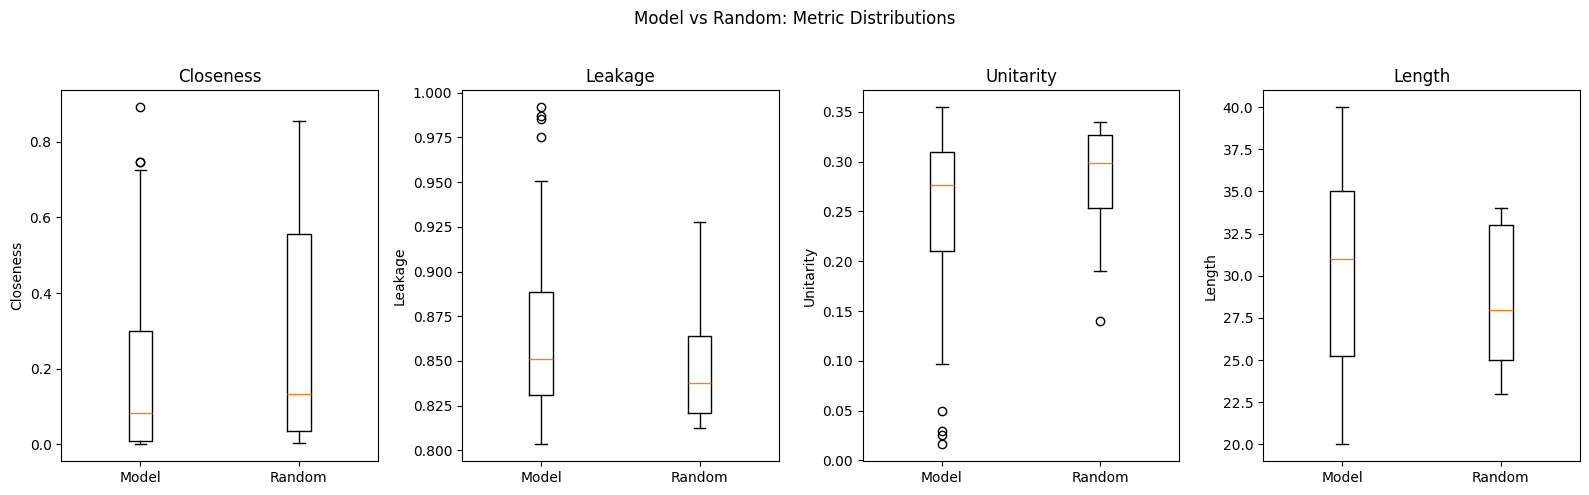

In [236]:
num_iters = 1000

random_records = collect_random_metrics(env, num_sequences=num_iters,
                                        min_length=21, max_length=40,
                                        closeness_thresh=1.0, leakage_thresh=0.8)
df_random = pd.DataFrame(random_records)



model_recs = collect_gate_metrics(vec_env, loaded_model, num_sequences=num_iters)

summary_df, p_vals = compare_models_statistics(model_recs, df_random)

# The following is test code and is inherently unstructured and messy

In [196]:
gates = [
    "7397799322", # 10
    "373373739737937373373", #21
    "373373733743000773323", #21
    "373323393737332975373" #21
    "373373787477337373373", #21
    "373373733743035223733", #21
    "373373747337334323737", #21
    "70747074804807470770", #20
    "74715417175771747519" #20
]

In [166]:
def string_to_gate_composition(gate_string: str, braid_gates: list) -> np.ndarray:
    # Initialize composition as the 5x5 identity matrix.
    composition = np.eye(5, dtype=complex)

    # Iterate over each character in the string.
    for char in gate_string:
        # Convert the character to an integer index.
        try:
            gate_index = int(char)
        except ValueError:
            raise ValueError(f"Invalid character '{char}' in gate string. Must be a digit.")

        # Check that the index is within the valid range.
        if gate_index < 0 or gate_index >= len(braid_gates):
            raise IndexError(f"Gate index {gate_index} is out of bounds for the available braid gates.")

        # Multiply the current composition by the braid gate.
        composition = composition @ braid_gates[gate_index]
    
    return composition


In [194]:
def print_gate_metrics(gate_strings, env, csv_filename="gate_metrics.csv"):
    # Determine the maximum width for the "Operator" column for nice formatting.
    max_operator_width = max(len(str(g)) for g in gate_strings)
    operator_column_width = max(max_operator_width, 10)  # Ensure at least 10 characters for aesthetics

    # Print table header to the console
    header = (f"{'Operator':<{operator_column_width}} | "
              f"{'Closeness':<10} | {'Leakage':<10} | {'Unitarity':<10}")
    print(header)
    print("-" * (operator_column_width + 34))

    # Open CSV file for writing the results.
    with open(csv_filename, "w", newline="") as csvfile:
        fieldnames = ["Operator", "Closeness", "Leakage", "Unitarity"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Process each gate string.
        for gate_str in gate_strings:
            # Reset the current composition in the environment.
            env.reset_composition()
            
            # Compute the gate composition for the given string.
            gate_matrix = env.get_gate_composition(gate_str)
            
            # Update the environment's composition to the computed gate.
            env.current_composition = gate_matrix
            
            # Compute the metrics for the current composition.
            leakage, closeness_error, unitarity_error, total_error = env.compute_reward()
            
            # Optionally, set unitarity error to exactly zero if very small.
            if unitarity_error < 0.0001:
                unitarity_error = 0.0
            
            # Format and print the row with the gate metrics.
            print(f"{gate_str:<{operator_column_width}} | "
                  f"{closeness_error:<10.3e} | "
                  f"{leakage:<10.3f} | "
                  f"{unitarity_error:<10.3e}")
            
            # Write the row to the CSV file
            writer.writerow({
                "Operator": gate_str,
                "Closeness": f"{closeness_error:.3e}",
                "Leakage": f"{leakage:.3f}",
                "Unitarity": f"{unitarity_error:.3e}"
            })

    print(f"Gate metrics have been written to {csv_filename}")


In [ ]:
"""
test = ["30",
        "880",
        "5300",
        "48440",
        "553000",
        "4334300",
        "37770000",
        "441001048",
        "2555337582",
        "59672955693",
        "374050007970",
        "306947382105",
        "6595888969003",
        "75139699757375",
        "78450807782427077787",
        "287430798424700981936977"
        ]
"""
"""
test = [
    "000",
    "0000",
    "00000",
    "222000",
    "0000000",
    "00000000",
    "000000000",
    "2221001222",
    "22210012220",
    "223443100122",
    "2213404301242",
    "34224334310031224",
    "242314040312211412221",
    "422211222020214000112021",
    "101422102223130431111322222",
    "31423322434332420442310301422",
    "222223043422422024043333320003",
    "2344130440331032213334400344312",
    "423330314001220244224333334034032",
    "132424244140142042111112011202122020400",
    "231333001244422220433403402422343302043"
]
"""

In [191]:
found_gates = [
    "373373739737937373373", #21
    "373373733743000773323", #21
    "373323393737332975373" #21
    "373373787477337373373", #21
    "373373733743035223733", #21
    "373373747337334323737", #21
    "70747074804807470770", #20
    "74715417175771747519", #20
    "124543537528586425295552041721248", 
    "3304508631218099892215222273419788357195",
    "2522122520252241121222952",
    "2122521290220262257522525",
    "212212922221206520262657",
    "252282524225252528922929527272252",
    "29220239322922922922920222292927209229",
    "7545960196017659606465541914747",
    "226262460644262626167206626272090226",
    "246060662626072722621262727272727206626",
    "272776262720226242026442267",
    "27272722626202724625625226244616",
    "27226262721242606620229262026226262622",
    "7397799322",
    "373373739737937373373",
    "373373733743000773323",
    "2262620207742620262",
    "206724676460242606626764692627272720202",
    "226262020662676402622629720127202662",
    "2262627262020662620962262",
    "22626246064426262606626242026",
    "2262624672064427262672722672066262427242",
    "272262627246727292020662620962267922"
    ]

In [192]:
def reduce_sequence(seq: str) -> str:
    
    # Inverse mapping: each key is the inverse of its value.
    inv_map = {
        '0': '5', '1': '6', '2': '7', '3': '8', '4': '9',
        '5': '0', '6': '1', '7': '2', '8': '3', '9': '4'
    }
    
    stack = []
    for char in seq:
        # Check if the last element in stack is the inverse of current char.
        if stack and inv_map[char] == stack[-1]:
            stack.pop()
        else:
            stack.append(char)
    
    return ''.join(stack)

In [ ]:
reduced_found_gates = []

 # Process and print the reduced sequences
for i, seq in enumerate(found_gates, 1):
    reduced = reduce_sequence(seq)
    print(f"Sequence {i}: Original: {seq}")
    print(f"            Reduced:  {reduced}\n")
    reduced_found_gates.append(reduced)

In [ ]:
env = GateApproxEnv(
    braid_gates=braid_gates,
    target_gate=target_gate,
    subs=subs,
    max_length=SEQUENCE_LENGTH,
    alpha=ALPHA,
    beta=BETA,
    gamma=GAMMA,
    local_equivalence_class=True
)
print_gate_metrics(reduced_found_gates, env)
